In [334]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary

In [335]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [336]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torchmetrics

In [337]:
RANDOM_SEED = 42
n_samples = 1000
X, y = make_moons(n_samples, random_state=42, noise=0.1)

X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [339]:
class MoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=15),
            nn.Tanh(),
            nn.Linear(in_features=15, out_features=15),
            nn.Tanh(),
            nn.Linear(in_features=15, out_features=15),
            nn.Tanh(),
            nn.Linear(in_features=15, out_features=1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn_stack(x)

moon_model = MoonsNet()
moon_model

MoonsNet(
  (nn_stack): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): Tanh()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [340]:
moon_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model.parameters(), lr = 0.01)

In [341]:
moon_model.to(device)

X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [342]:
tmp_val = moon_model(X_train).squeeze()

print(torch.sigmoid(tmp_val)[:5])
print(torch.round(torch.sigmoid(tmp_val))[:5])

tensor([0.5060, 0.4888, 0.4806, 0.4822, 0.5088], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([1., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SliceBackward0>)


In [343]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct /len(y_preds)) * 100
    return acc

In [344]:
epochs = 5000

for epoch in range(epochs):
    moon_model.train()
    # forward pass
    moon_train_logits = moon_model(X_train).squeeze()
    moon_train_preds = torch.round(torch.sigmoid(moon_train_logits))
    
    tmp = torch.unique(moon_train_preds)
    #print(tmp)
    #print(len(moon_train_preds), len(y_train))
    # accuracy and loss
    loss = moon_loss_fn(moon_train_logits, y_train)
    acc = torchmetrics.functional.accuracy(moon_train_preds.type(torch.int), y_train.type(torch.int))
    #acc = accuracy_fn(y_true=y_train, y_preds = moon_train_preds)
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    moon_model.eval()
    with torch.inference_mode():
        moon_test_logits = moon_model(X_test).squeeze()
        moon_test_preds = torch.round(torch.sigmoid(moon_test_logits))
        
        moon_test_loss = moon_loss_fn(moon_test_logits, y_test)
        moon_test_acc = accuracy(moon_test_preds.type(torch.int), y_test.type(torch.int))
        #moon_test_acc = accuracy_fn(y_true=y_test, y_preds=moon_test_preds)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss}, Train Acc: {acc} | Test Loss: {moon_test_loss}, Test Acc: {moon_test_acc}")

Epoch: 0 | Train Loss: 0.6755398511886597, Train Acc: 0.8712499737739563 | Test Loss: 0.6756942868232727, Test Acc: 0.8550000190734863
Epoch: 10 | Train Loss: 0.6687870621681213, Train Acc: 0.8525000214576721 | Test Loss: 0.6695643663406372, Test Acc: 0.8399999737739563
Epoch: 20 | Train Loss: 0.6620504856109619, Train Acc: 0.84375 | Test Loss: 0.6634397506713867, Test Acc: 0.8399999737739563
Epoch: 30 | Train Loss: 0.655278742313385, Train Acc: 0.8399999737739563 | Test Loss: 0.6572750210762024, Test Acc: 0.8349999785423279
Epoch: 40 | Train Loss: 0.64842689037323, Train Acc: 0.8374999761581421 | Test Loss: 0.6510298252105713, Test Acc: 0.8299999833106995
Epoch: 50 | Train Loss: 0.641455352306366, Train Acc: 0.8362500071525574 | Test Loss: 0.6446689963340759, Test Acc: 0.8149999976158142
Epoch: 60 | Train Loss: 0.6343302726745605, Train Acc: 0.8287500143051147 | Test Loss: 0.6381627917289734, Test Acc: 0.8149999976158142
Epoch: 70 | Train Loss: 0.6270233392715454, Train Acc: 0.8274999

Epoch: 610 | Train Loss: 0.32902801036834717, Train Acc: 0.84375 | Test Loss: 0.34412050247192383, Test Acc: 0.8399999737739563
Epoch: 620 | Train Loss: 0.32718154788017273, Train Acc: 0.8450000286102295 | Test Loss: 0.34182727336883545, Test Acc: 0.8399999737739563
Epoch: 630 | Train Loss: 0.3253738284111023, Train Acc: 0.8450000286102295 | Test Loss: 0.33957263827323914, Test Acc: 0.8399999737739563
Epoch: 640 | Train Loss: 0.32360321283340454, Train Acc: 0.8450000286102295 | Test Loss: 0.3373555541038513, Test Acc: 0.8399999737739563
Epoch: 650 | Train Loss: 0.3218681514263153, Train Acc: 0.8450000286102295 | Test Loss: 0.33517515659332275, Test Acc: 0.8399999737739563
Epoch: 660 | Train Loss: 0.32016730308532715, Train Acc: 0.8450000286102295 | Test Loss: 0.3330305814743042, Test Acc: 0.8399999737739563
Epoch: 670 | Train Loss: 0.3184995949268341, Train Acc: 0.8450000286102295 | Test Loss: 0.3309212028980255, Test Acc: 0.8399999737739563
Epoch: 680 | Train Loss: 0.31686392426490784

Epoch: 1240 | Train Loss: 0.266327440738678, Train Acc: 0.8824999928474426 | Test Loss: 0.2614322304725647, Test Acc: 0.8949999809265137
Epoch: 1250 | Train Loss: 0.2659814953804016, Train Acc: 0.8824999928474426 | Test Loss: 0.2609178125858307, Test Acc: 0.8949999809265137
Epoch: 1260 | Train Loss: 0.2656461298465729, Train Acc: 0.8837500214576721 | Test Loss: 0.26041746139526367, Test Acc: 0.8949999809265137
Epoch: 1270 | Train Loss: 0.26532089710235596, Train Acc: 0.8837500214576721 | Test Loss: 0.25993070006370544, Test Acc: 0.8949999809265137
Epoch: 1280 | Train Loss: 0.26500532031059265, Train Acc: 0.8837500214576721 | Test Loss: 0.25945696234703064, Test Acc: 0.8949999809265137
Epoch: 1290 | Train Loss: 0.26469898223876953, Train Acc: 0.8837500214576721 | Test Loss: 0.25899580121040344, Test Acc: 0.8949999809265137
Epoch: 1300 | Train Loss: 0.2644014358520508, Train Acc: 0.8837500214576721 | Test Loss: 0.2585466802120209, Test Acc: 0.8949999809265137
Epoch: 1310 | Train Loss: 0.

Epoch: 1850 | Train Loss: 0.25381872057914734, Train Acc: 0.8924999833106995 | Test Loss: 0.24298417568206787, Test Acc: 0.8999999761581421
Epoch: 1860 | Train Loss: 0.25364962220191956, Train Acc: 0.8924999833106995 | Test Loss: 0.24276283383369446, Test Acc: 0.8999999761581421
Epoch: 1870 | Train Loss: 0.2534797489643097, Train Acc: 0.8924999833106995 | Test Loss: 0.24254147708415985, Test Acc: 0.8999999761581421
Epoch: 1880 | Train Loss: 0.253309041261673, Train Acc: 0.8924999833106995 | Test Loss: 0.24232006072998047, Test Acc: 0.8999999761581421
Epoch: 1890 | Train Loss: 0.2531374990940094, Train Acc: 0.8924999833106995 | Test Loss: 0.24209849536418915, Test Acc: 0.8999999761581421
Epoch: 1900 | Train Loss: 0.2529650032520294, Train Acc: 0.8924999833106995 | Test Loss: 0.2418767511844635, Test Acc: 0.8999999761581421
Epoch: 1910 | Train Loss: 0.2527915835380554, Train Acc: 0.893750011920929 | Test Loss: 0.24165473878383636, Test Acc: 0.8999999761581421
Epoch: 1920 | Train Loss: 0.

Epoch: 2510 | Train Loss: 0.2392522394657135, Train Acc: 0.8999999761581421 | Test Loss: 0.22592796385288239, Test Acc: 0.9049999713897705
Epoch: 2520 | Train Loss: 0.23895223438739777, Train Acc: 0.8999999761581421 | Test Loss: 0.22559773921966553, Test Acc: 0.9049999713897705
Epoch: 2530 | Train Loss: 0.23864899575710297, Train Acc: 0.8999999761581421 | Test Loss: 0.22526441514492035, Test Acc: 0.9049999713897705
Epoch: 2540 | Train Loss: 0.2383425533771515, Train Acc: 0.8999999761581421 | Test Loss: 0.22492791712284088, Test Acc: 0.9049999713897705
Epoch: 2550 | Train Loss: 0.23803278803825378, Train Acc: 0.8999999761581421 | Test Loss: 0.22458823025226593, Test Acc: 0.9049999713897705
Epoch: 2560 | Train Loss: 0.23771969974040985, Train Acc: 0.8999999761581421 | Test Loss: 0.2242453396320343, Test Acc: 0.9049999713897705
Epoch: 2570 | Train Loss: 0.2374032586812973, Train Acc: 0.8999999761581421 | Test Loss: 0.22389911115169525, Test Acc: 0.9100000262260437
Epoch: 2580 | Train Loss

Epoch: 3170 | Train Loss: 0.21052104234695435, Train Acc: 0.9087499976158142 | Test Loss: 0.19542697072029114, Test Acc: 0.9150000214576721
Epoch: 3180 | Train Loss: 0.20991209149360657, Train Acc: 0.9100000262260437 | Test Loss: 0.19479718804359436, Test Acc: 0.9150000214576721
Epoch: 3190 | Train Loss: 0.20929694175720215, Train Acc: 0.9100000262260437 | Test Loss: 0.1941615790128708, Test Acc: 0.9150000214576721
Epoch: 3200 | Train Loss: 0.20867560803890228, Train Acc: 0.9100000262260437 | Test Loss: 0.19352012872695923, Test Acc: 0.9150000214576721
Epoch: 3210 | Train Loss: 0.208048015832901, Train Acc: 0.9100000262260437 | Test Loss: 0.19287274777889252, Test Acc: 0.9150000214576721
Epoch: 3220 | Train Loss: 0.20741420984268188, Train Acc: 0.9100000262260437 | Test Loss: 0.19221946597099304, Test Acc: 0.9150000214576721
Epoch: 3230 | Train Loss: 0.206774041056633, Train Acc: 0.9100000262260437 | Test Loss: 0.1915602684020996, Test Acc: 0.9150000214576721
Epoch: 3240 | Train Loss: 

Epoch: 3780 | Train Loss: 0.16177164018154144, Train Acc: 0.9325000047683716 | Test Loss: 0.1463950276374817, Test Acc: 0.9350000023841858
Epoch: 3790 | Train Loss: 0.16079340875148773, Train Acc: 0.9325000047683716 | Test Loss: 0.1454356610774994, Test Acc: 0.9350000023841858
Epoch: 3800 | Train Loss: 0.15981097519397736, Train Acc: 0.9325000047683716 | Test Loss: 0.14447303116321564, Test Acc: 0.9350000023841858
Epoch: 3810 | Train Loss: 0.15882447361946106, Train Acc: 0.9325000047683716 | Test Loss: 0.14350730180740356, Test Acc: 0.9350000023841858
Epoch: 3820 | Train Loss: 0.1578340381383896, Train Acc: 0.9325000047683716 | Test Loss: 0.14253857731819153, Test Acc: 0.9350000023841858
Epoch: 3830 | Train Loss: 0.15683980286121368, Train Acc: 0.9325000047683716 | Test Loss: 0.14156699180603027, Test Acc: 0.9350000023841858
Epoch: 3840 | Train Loss: 0.1558419167995453, Train Acc: 0.9337499737739563 | Test Loss: 0.14059272408485413, Test Acc: 0.9350000023841858
Epoch: 3850 | Train Loss

Epoch: 4410 | Train Loss: 0.09856075048446655, Train Acc: 0.96875 | Test Loss: 0.08603931218385696, Test Acc: 0.9850000143051147
Epoch: 4420 | Train Loss: 0.09765159338712692, Train Acc: 0.9700000286102295 | Test Loss: 0.08519429713487625, Test Acc: 0.9850000143051147
Epoch: 4430 | Train Loss: 0.09674880653619766, Train Acc: 0.9700000286102295 | Test Loss: 0.08435584604740143, Test Acc: 0.9850000143051147
Epoch: 4440 | Train Loss: 0.09585252404212952, Train Acc: 0.9700000286102295 | Test Loss: 0.08352404087781906, Test Acc: 0.9850000143051147
Epoch: 4450 | Train Loss: 0.09496284276247025, Train Acc: 0.9712499976158142 | Test Loss: 0.08269897103309631, Test Acc: 0.9850000143051147
Epoch: 4460 | Train Loss: 0.0940798670053482, Train Acc: 0.9712499976158142 | Test Loss: 0.08188070356845856, Test Acc: 0.9850000143051147
Epoch: 4470 | Train Loss: 0.09320365637540817, Train Acc: 0.9712499976158142 | Test Loss: 0.08106929808855057, Test Acc: 0.9850000143051147
Epoch: 4480 | Train Loss: 0.0923

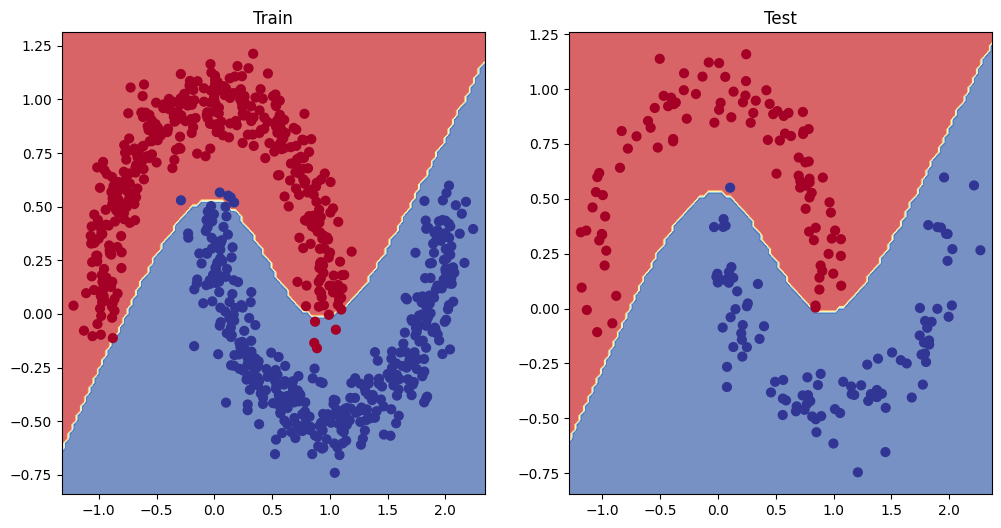

In [345]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)

In [347]:
def tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

tanh(torch.tensor(2))

tensor(0.9640)

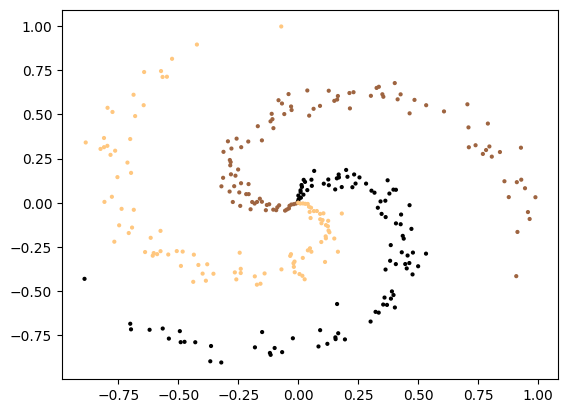

In [364]:
import numpy as np
N = 100
D = 2
K = 3
X = np.zeros((N*K, D)) # data matrix
y = np.zeros((N*K), dtype="uint8") #class Labels

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

plt.scatter(X[:, 0], X[:, 1], c=y, s=4, cmap=plt.cm.copper)

In [396]:
class CS231(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=3)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn_stack(x)

spiral_model = CS231()
spiral_model.to(device)
spiral_model

CS231(
  (nn_stack): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=3, bias=True)
  )
)

In [397]:
spiral_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = spiral_model.parameters(), lr = 0.1)

In [398]:
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_spiral_train = torch.from_numpy(X_spiral_train).type(torch.float).to(device)
X_spiral_test  = torch.from_numpy(X_spiral_test).type(torch.float).to(device)
y_spiral_train = torch.from_numpy(y_spiral_train).type(torch.uint8).to(device)
y_spiral_test = torch.from_numpy(y_spiral_test).type(torch.uint8).to(device)

In [399]:
epochs = 2000

for epoch in range(epochs):
    spiral_model.train()
    
    train_logits = spiral_model(X_spiral_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
    
    train_loss = spiral_loss(train_logits, y_spiral_train)
    train_acc = torchmetrics.functional.accuracy(train_preds, y_spiral_train)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    spiral_model.eval()
    with torch.inference_mode():
        test_logits = spiral_model(X_spiral_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = spiral_loss(test_logits, y_spiral_test)
        test_acc = torchmetrics.functional.accuracy(test_preds, y_spiral_test)
        
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train Loss: {train_loss}, Train Acc: {train_acc} | Test Loss: {test_loss}, Test Acc: {test_acc}")
    

Epoch: 0 | Train Loss: 1.0885897874832153, Train Acc: 0.3499999940395355 | Test Loss: 1.0052357912063599, Test Acc: 0.5
Epoch: 100 | Train Loss: 0.02035234309732914, Train Acc: 0.9916666746139526 | Test Loss: 0.002057620557025075, Test Acc: 1.0
Epoch: 200 | Train Loss: 0.015765072777867317, Train Acc: 0.9916666746139526 | Test Loss: 0.00025691348128020763, Test Acc: 1.0
Epoch: 300 | Train Loss: 0.015122954733669758, Train Acc: 0.9916666746139526 | Test Loss: 0.00016738900740165263, Test Acc: 1.0
Epoch: 400 | Train Loss: 0.015212463214993477, Train Acc: 0.9916666746139526 | Test Loss: 0.0008824367541819811, Test Acc: 1.0
Epoch: 500 | Train Loss: 0.015640411525964737, Train Acc: 0.9916666746139526 | Test Loss: 0.006217955611646175, Test Acc: 1.0
Epoch: 600 | Train Loss: 0.014750311151146889, Train Acc: 0.9916666746139526 | Test Loss: 0.012965223751962185, Test Acc: 0.9833333492279053
Epoch: 700 | Train Loss: 0.014790146611630917, Train Acc: 0.9916666746139526 | Test Loss: 0.0230725333094

In [400]:
spiral_model.eval()
with torch.inference_mode():
    y_predicted = torch.softmax(spiral_model(X_test), dim=1).argmax(dim=1)
y_predicted[:5]

tensor([0, 1, 1, 1, 1], device='cuda:0')

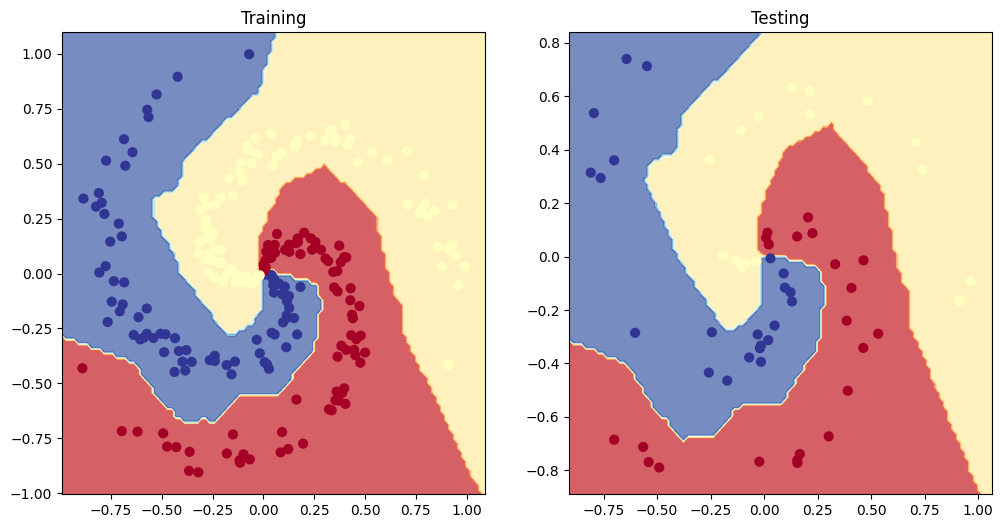

In [401]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(spiral_model, X_spiral_train, y_spiral_train)
plt.subplot(1,2,2)
plt.title("Testing")
plot_decision_boundary(spiral_model, X_spiral_test, y_spiral_test)